In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
from tqdm import tqdm

from metric_learn import LMNN
from sklearn.model_selection import StratifiedKFold

In [ ]:
warnings.filterwarnings("ignore")

In [2]:
data = loadmat('PaviaU.mat')['paviaU']

gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))  #düzleştirip dataframe oluşturuyoruz

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

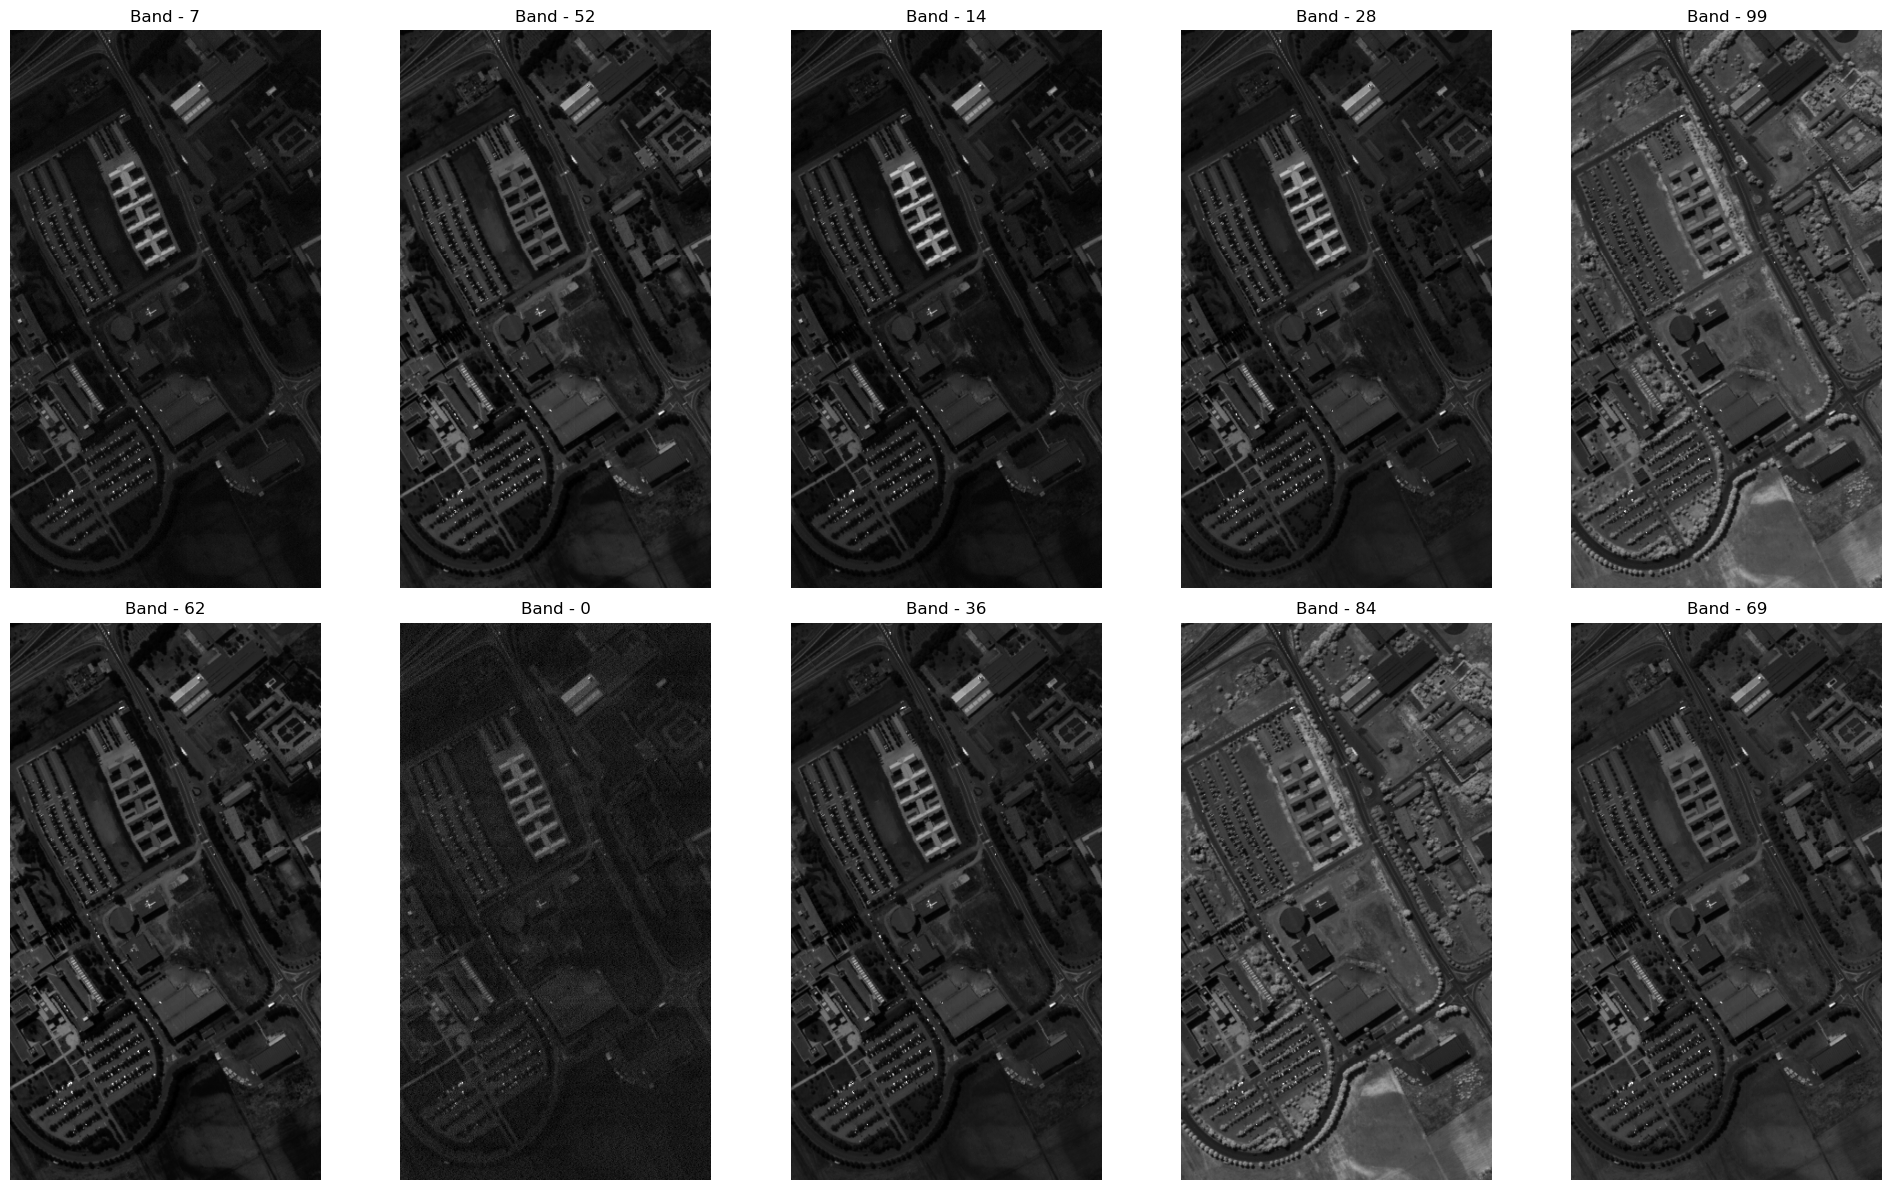

In [3]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()

plt.show()

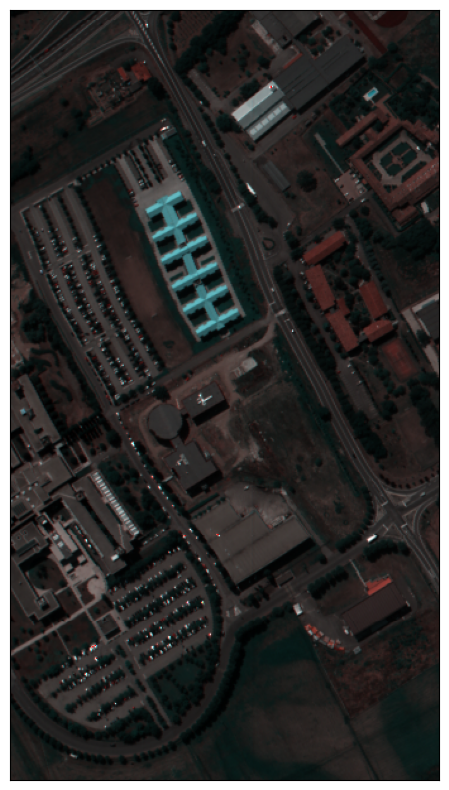

In [4]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10))

plt.show()

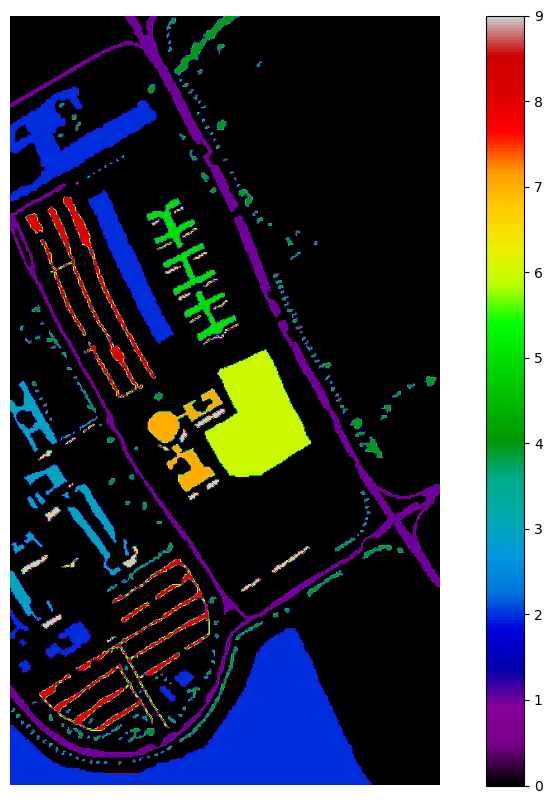

In [5]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [6]:
X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [8]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import RCA_Supervised
from sklearn.impute import SimpleImputer

veri = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rca = RCA_Supervised(n_chunks=30, chunk_size=2)
knn = KNeighborsClassifier(n_neighbors=7)

fold_index = 1
for test_index, train_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    # Veri setini train ve test olarak bölmek
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Eksik değerleri kontrol etmek ve ortalama ile doldurmak
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    # Modeli eğitme
    rca.fit(X_train, y_train)
    knn.fit(X_train, y_train)


    rca_acc = knn.score(X_test, y_test)
    print('RCA_Supervised accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], rca_acc))

    veri.append(rca_acc)

    fold_index += 1
    
# Dizinin ortalamasını bulalım
ortalama = np.mean(veri)

# Dizinin standart sapmasını bulalım
standart_sapma = np.std(veri)

print("Veri kümesinin ortalaması:", ortalama)
print("Veri kümesinin standart sapması:", standart_sapma)

Fold 1 -> Train: 8556, Test: 34220
RCA_Supervised accuracy on test set of 34220 points: 0.8830
Fold 2 -> Train: 8555, Test: 34221
RCA_Supervised accuracy on test set of 34221 points: 0.8795
Fold 3 -> Train: 8555, Test: 34221
RCA_Supervised accuracy on test set of 34221 points: 0.8840
Fold 4 -> Train: 8555, Test: 34221
RCA_Supervised accuracy on test set of 34221 points: 0.8781
Fold 5 -> Train: 8555, Test: 34221
RCA_Supervised accuracy on test set of 34221 points: 0.8819
Veri kümesinin ortalaması: 0.8813178049830501
Veri kümesinin standart sapması: 0.0021985823674317314


In [9]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8818853920107537
Confusion Matrix:
[[ 4753    30   107     0    13    47   230   142     0]
 [    0 14661     0    71     0   257     0     6     0]
 [  131     7  1186     0     0     4     2   366     0]
 [    0   403     0  1977     1     9     0     0     0]
 [    2     0     2     0  1072     3     0     2     0]
 [   13  1508     3     2     0  2446     0    15     0]
 [  152     0    11     0     0     0   899     2     0]
 [  127    23   325     0     0    18     7  2435     0]
 [    1     0     0     0     0     0     0     0   750]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.89      0.91      5322
           2       0.88      0.98      0.93     14995
           3       0.73      0.70      0.71      1696
           4       0.96      0.83      0.89      2390
           5       0.99      0.99      0.99      1081
           6       0.88      0.61      0.72      3987
           7       0.79      0.84    

In [10]:
from sklearn.metrics import accuracy_score

# Genel doğruluk hesaplama
genel_dogruluk = accuracy_score(y_test, y_pred)
print("Genel Doğruluk:", genel_dogruluk)

Genel Doğruluk: 0.8818853920107537


In [11]:
from sklearn.metrics import f1_score

# F-Measure hesaplama
f_measure = f1_score(y_test, y_pred, average='macro')
print("F-Measure:", f_measure)

F-Measure: 0.8653296531444055


In [12]:
from sklearn.metrics import cohen_kappa_score

# Kappa değeri hesaplama
kappa_degeri = cohen_kappa_score(y_test, y_pred)
print("Kappa Değeri:", kappa_degeri)

Kappa Değeri: 0.8398480284880485
